In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [3]:
train_df_path ='../07. Pemodelan Data (Data Mining)/dataset/Dataset_Clean(penelitian).csv'


In [4]:
train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['full_text', 'emotion']

In [5]:
train_df.head(10)

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,Neutral
1,baru mengirim foto,Neutral
2,apa kabar dunia twitter masihkah selucu seabsu...,Neutral
3,yah gimana sih yaudah susul sebelumnya sarapan...,Neutral
4,ka dorg suro beli medium set,Neutral
5,ayo cek koleksinya temukan angry draken unik n...,Neutral
6,kalau biasa biasa sudah,Neutral
7,tiap tiap twit tak selalu perlu pesan moral ka...,Neutral
8,halo v apa kabar nih,Neutral
9,pagi ruby apa kabar,Neutral


In [6]:
def get_label_idx(label):
    if label == 'Fear':
        return 5
    elif label == 'Sad':
        return 4
    elif label == 'Love':
        return 3
    elif label == 'Joy':
        return 2
    elif label == 'Anger':
        return 1
    elif label == 'Neutral':
        return 0


train_df['emotion'] = train_df['emotion'].apply(get_label_idx)


In [7]:
#hapus label selain 0-5
train_df = train_df[train_df['emotion'] <= 5]


In [8]:
train_df

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,0
1,baru mengirim foto,0
2,apa kabar dunia twitter masihkah selucu seabsu...,0
3,yah gimana sih yaudah susul sebelumnya sarapan...,0
4,ka dorg suro beli medium set,0
...,...,...
28695,ingin sangat nih daerah jakarta barat tidak si,0
28696,selamat hari raya tri suci waisak seluruh umat...,2
28697,kandungan serat passion fruit markisa berfungs...,3
28698,selamat memperingati hari kebangkitan nasional...,2


# Define the function to join the list of tokens as a single document string
def join_text_list(texts):
    try:
        texts = ast.literal_eval(texts)
        return ' '.join([text for text in texts])
    except (ValueError, SyntaxError):
        return None  # or return an empty string if you prefer

# Apply the function to the 'full_text' column
train_df["full_text"] = train_df["full_text"].apply(join_text_list)

# Display the first few rows of the preprocessed column
train_df

In [9]:
jumlah_netral = len(train_df[train_df['emotion'] == 0])
jumlah_marah = len(train_df[train_df['emotion'] == 1])
jumlah_senang = len(train_df[train_df['emotion'] == 2])
jumlah_cinta = len(train_df[train_df['emotion'] == 3])
jumlah_sedih = len(train_df[train_df['emotion'] == 4])
jumlah_takut = len(train_df[train_df['emotion'] == 5])

print("Jumlah Netral: ", jumlah_netral)
print("Jumlah Marah: ", jumlah_marah)
print("Jumlah Senang: ", jumlah_senang)
print("Jumlah Cinta: ", jumlah_cinta)
print("Jumlah Sedih: ", jumlah_sedih)
print("Jumlah Takut: ", jumlah_takut)

Jumlah Netral:  3550
Jumlah Marah:  5757
Jumlah Senang:  6638
Jumlah Cinta:  4411
Jumlah Sedih:  4857
Jumlah Takut:  3487


In [10]:
# Split dataset menjadi fitur (X) dan label (y)
X_train = train_df['full_text']
y_train = train_df['emotion']


In [11]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [12]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((25830,), (2870,), (25830,), (2870,))

## Generate Padded Sequence

In [13]:
# Parameters

vocab_size = 60000 
max_length = 64 
embedding_dim = 8 
trunc_type='post' 
oov_tok = "<OOV>" 

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Define the "all_texts" variable
X_train = [str(text) for text in X_train]
X_valid = [str(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [15]:
X_train

['enak parss',
 'kelakuanmu mencerminkan kelakuan pasanganmu kalau menyebalkan iya siap punya pasangan menyebalkan teman ini sih apa',
 'cinta menerima kelebihan kekurangan seseorang melihat potensi tersembunyi setiap individu',
 'fadli zon upaya penggiringan opini prabowo tak jadi capres',
 'huhu iya sedih tidak rela',
 'waktu datang counter texas kata mbak jaganya ada promo beli french fries ribu p',
 'kalau jujur sekarang masih sepenuhnya menerima perilaku sopan orang yang berusaha keluar masuk hubungan sebelumnya merasa adil pernah ngerusak hubungan orang sekarang kalau saya ingat caranya masuk saya tidak habis pikir',
 'mungkin si nalarnya sehat fans persija semua penyanyi dangdut seronok goyangannya via vallen sopan kok bung',
 'tanggal melakukan pembayaraan pelunasan lewat atm bri bukti pembayaran ada total pelunasan rp itu ada sms notifikasi tunaikita masalah pelunasaan telepon chat email saya coba tidak ada respon kecewa sekali sama pelayanannya sprti',
 'emosi mentionan sama 

In [16]:
y_train

5332     2
18966    1
18512    3
20902    3
3585     4
        ..
21575    2
5390     2
860      0
15795    4
23654    0
Name: emotion, Length: 25830, dtype: int64

### kamus data untuk api Training

In [17]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [18]:
print(train_padded[0])

[   81 23064     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


## Word Embedding

In [19]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=1, workers=4)

In [20]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [21]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70540923, -2.41742134,  2.69996309, ...,  1.71836722,
         4.00581598, -4.84541655],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

('walaupun', array([-0.21712258, -0.70870119,  1.34808052,  2.04478908,  1.76918077,
       -0.83602607,  3.09099865, -2.55141568]))


## Build and Compile Model

In [23]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    # tf.keras.layers.Embedding(vocab_size, 8, input_shape=(max_length,)),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    # tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\TEMP\miniconda3\envs\skripsi\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 64, 8)          │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 128)        │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,902 (2.10 MB)

 Trainable params: 70,902 (276.96 KB)

 Non-trainable params: 480,000 (1.83 MB)

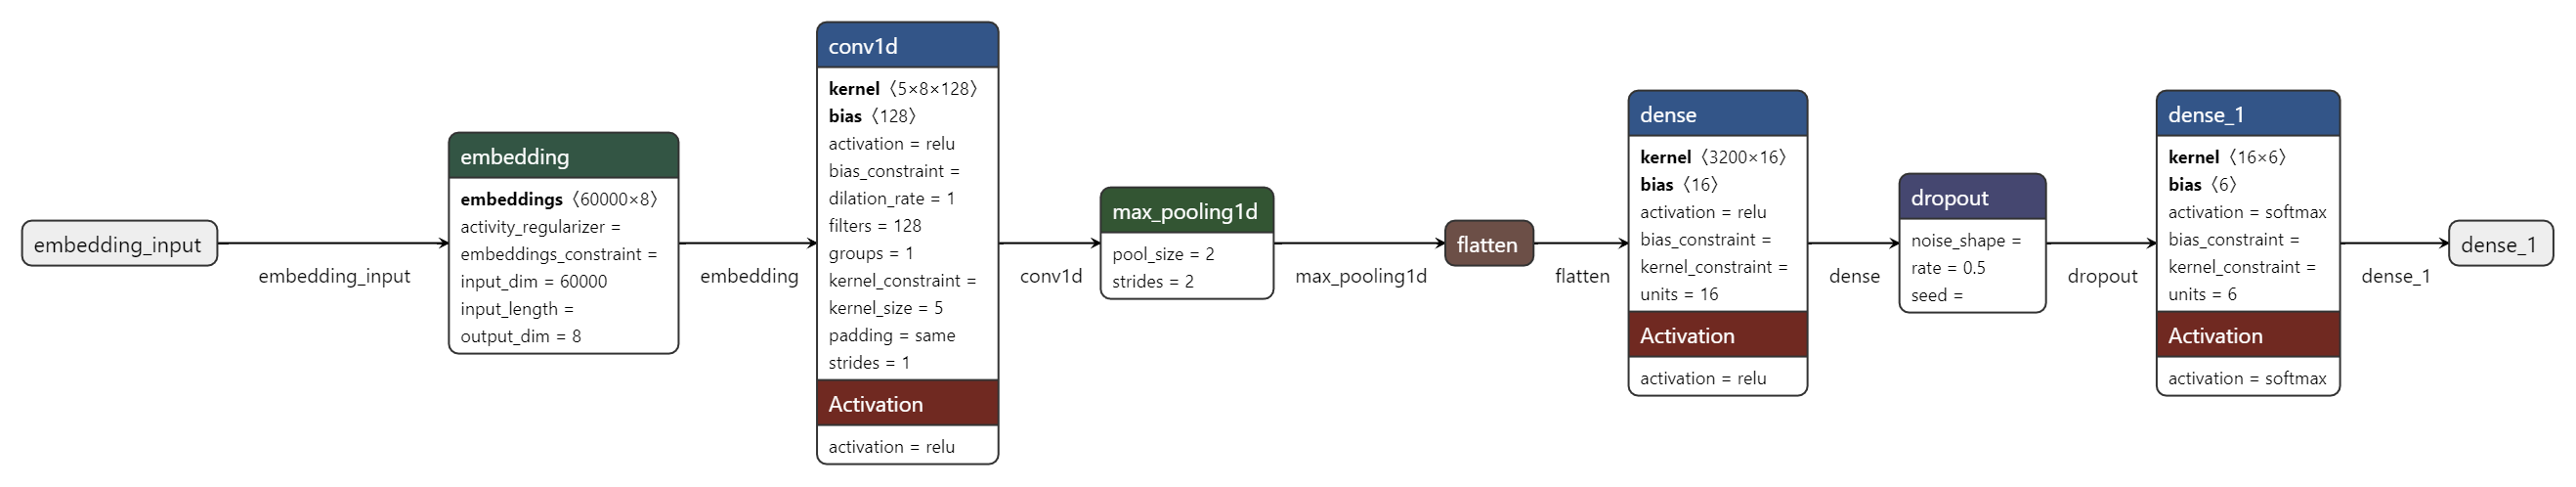

In [24]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.7054092 -2.4174213  2.699963  ...  1.7183672  4.005816  -4.8454165]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
Layer Name: conv1d
Weights Shape (Tensor 0): (5, 8, 128)
Weights (Tensor 0):
[[[ 0.00487566 -0.08569755  0.06123777 ... -0.0872063  -0.07896625
    0.04406866]
  [ 0.08180915 -0.01134208 -0.05463301 ...  0.060119    0.05875723
   -0.028804  ]
  [ 0.0001769   0.04624701 -0.08509554 ...  0.06809133 -0.02887589
    0.09107004]
  ...
  [-0.0333023   0.09378786  0.011085   ...  0.07153754  0.06682847
    0.01424002]
  [ 0.02917577 -0.01982111 -0.02808334 ... -0.09090046  0.0879

## Train Model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128, 
    epochs=num_epochs, 
    validation_data=(valid_padded, y_valid), 
)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2349 - loss: 1.7574 - val_accuracy: 0.3345 - val_loss: 1.6348
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3106 - loss: 1.6614 - val_accuracy: 0.3714 - val_loss: 1.5619
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3413 - loss: 1.5987 - val_accuracy: 0.3930 - val_loss: 1.5430
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3448 - loss: 1.5857 - val_accuracy: 0.3965 - val_loss: 1.5081
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3607 - loss: 1.5568 - val_accuracy: 0.4038 - val_loss: 1.4885
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3684 - loss: 1.5394 - val_accuracy: 0.4122 - val_loss: 1.4574
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3798 - loss: 1.5085 - val_accuracy: 0.4157 - val_loss: 1.4581
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3910 - loss: 1.4830 - val_ac

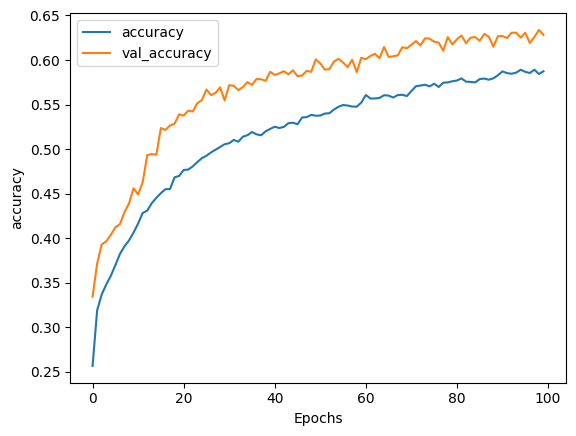

In [26]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

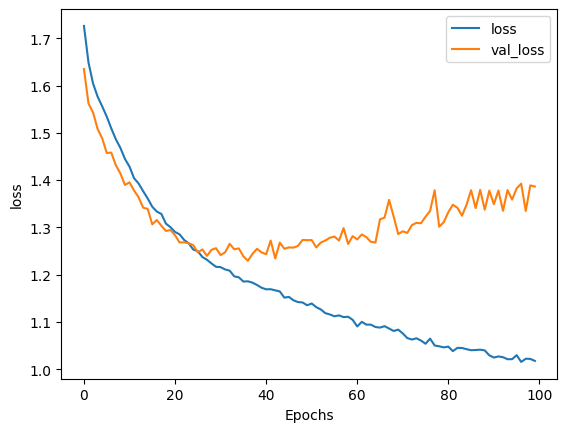

In [27]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [28]:
#sklearn report
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_valid, y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6272 - loss: 1.3966
Loss:  1.3864036798477173
Accuracy:  0.6282230019569397
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.37      0.26      0.31       306
           1       0.51      0.79      0.62       577
           2       0.68      0.72      0.70       647
           3       0.77      0.58      0.66       466
           4       0.76      0.66      0.71       492
           5       0.72      0.55      0.63       382

    accuracy                           0.63      2870
   macro avg       0.63      0.59      0.60      2870
weighted avg       0.65      0.63      0.63      2870



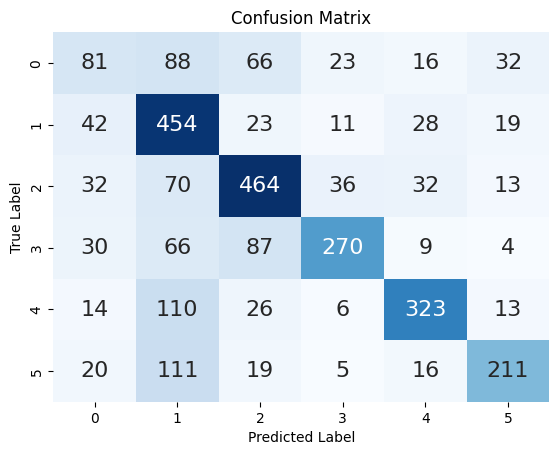

In [29]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [30]:
print(cm)

[[ 81  88  66  23  16  32]
 [ 42 454  23  11  28  19]
 [ 32  70 464  36  32  13]
 [ 30  66  87 270   9   4]
 [ 14 110  26   6 323  13]
 [ 20 111  19   5  16 211]]


In [31]:
#predict another data input from the model
def predict_emotion(text):
    # Tokenisasi
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi
    pred = model.predict(padded)

    print("Prediksi:", pred)
    pred = np.argmax(pred, axis=1)
    

    # Mengembalikan label emosi
    if pred == 0:
        return "Neutral"
    elif pred == 1:
        return "Anger"
    elif pred == 2:
        return "Joy"
    elif pred == 3:
        return "Love"
    elif pred == 4:
        return "Sad"
    elif pred == 5:
        return "Fear"

#make 10 senteces twitter in predict emotion
predict_emotion("saya sangat senang hari ini")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediksi: [[7.5520068e-02 1.6867322e-03 5.0314552e-01 3.7195265e-01 4.7542974e-02
  1.5205042e-04]]


'Joy'

In [32]:
#save model
model.save('./model/model-cnn.h5')

In [33]:
import pickle

with open('tokenizer-emotion(cnn).pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)